# Perfectly Vertical Grating Coupler (PVGC) Inverse Design


## Geometry

running luminescent python frontenda


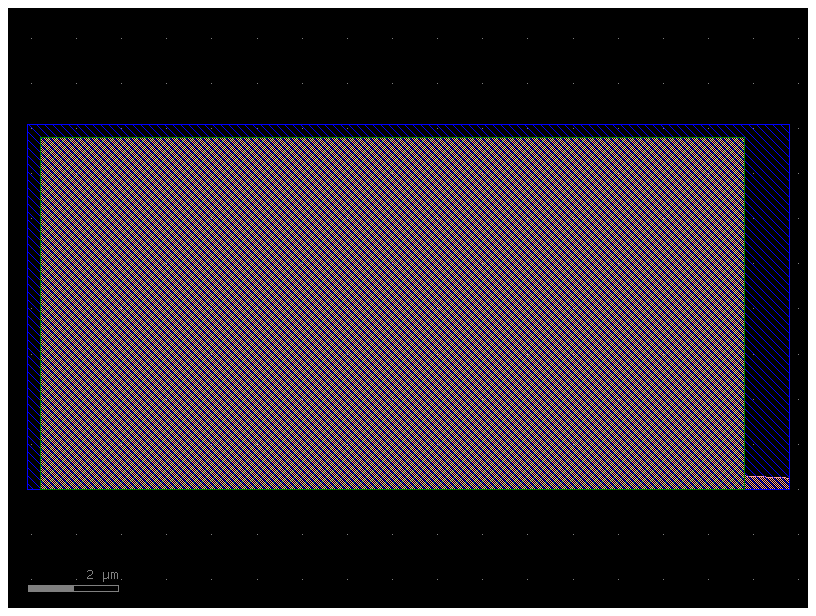

In [1]:
import os
import numpy as np
import luminescent as lumi
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import matplotlib.pyplot as plt

wideband = False
bidirectional = False

if wideband and bidirectional:
    study="wbPVGC" # wideband bidirectional
elif bidirectional:
    study="bPVGC" # bidirectional
else:
    study="PVGC"

# folder for saving config and results
path = os.path.join("studies", study)

wavelength=1.55
if wideband:
    bandwidth=.07
else:
    bandwidth = 0.005
wavelengths = np.linspace(wavelength-bandwidth/2, wavelength+bandwidth/2, 5)

eps_Si = 12.25
eps_SiO2 = 2.1708
n_Si = np.sqrt(eps_Si)
n_SiO2 = np.sqrt(eps_SiO2)
λ_Si=wavelength/n_Si
λ_SiO2=wavelength/n_SiO2

material_wg='Si'
material_clad = "SiO2"

material_library = {
    "Si": lumi.Material(eps_Si),
    "SiO2": lumi.Material(eps_SiO2),
}
material_library["background"] = material_library["SiO2"]  # set background material
material_library["design"] = lumi.PlaceholderMaterial(n_Si)

w = 10.4  # gaussian beam waist
r= w / 2  # source gaussian radius
R=1.5*r

if bidirectional:
    w_design =1*R  # of design region
    l_design =1.5 *R # of design region
else:
    w_design =1*R  # of design region
    l_design =2*R # of design region

w_wg = 0.5
l_wg = 2 * w_wg
h_wg = 0.22
d_etch = 0.07
h_slab = h_wg - d_etch

# margins
lateral_port_margin = height_port_margin = 1*h_wg
margin = 1.25 * lateral_port_margin
zmargin = 1.25 * height_port_margin

λ_Si=wavelength/n_Si
λ_SiO2=wavelength/n_SiO2

nres = 4  # number of grid points per wavelength in material (not vacuum)

dz=λ_SiO2/ nres
source_port_margin = 2*dz

gap1=zmargin
gap2=1/4*λ_SiO2
z_port = h_wg+gap1
zmin=-gap2
zmax=z_port+source_port_margin

WG = 1, 0
BBOX = 10, 0
DESIGN = 500, 0

# makes gdsfadory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left.
c = gf.Component()
taper=.1
design = c << lumi.mimo(
    l_design,
    w_design,
    east=[w_design-w_wg/4],
    w_wg=w_wg/2,
    l_wg=l_wg,
    layer_wg=WG,
    layer_design=DESIGN,
    taper=[(0, taper/2)],
    init=1,
)

source_port=f'o1'
c.add_port(f'o2', port=design.ports[f'o1'])

if bidirectional:
    c << gf.components.bbox(component=c, layer=BBOX, top=margin)
else:
    design.movex(-R)
    c << gf.components.bbox(component=c, layer=BBOX, top=margin,left=margin,)
c.plot()

## Solve

saving mode plots to /home/weihu/lumi/luminescent/studies/PVGC/modes/1


showing modes for first wavelength 
mode Boundary conditions: 000A
/home/weihu/lumi/luminescent/studies/PVGC/modes/1/1.55 mode 0 (neff=0.424+0.000j)
/home/weihu/lumi/luminescent/studies/PVGC/modes/1/1.55 mode 1 (neff=0.000+1.363j)
saving mode plots to /home/weihu/lumi/luminescent/studies/PVGC/modes/2
using simulation folder /home/weihu/lumi/luminescent/studies/PVGC
0.05535714285714286
Loading mesh from: /home/weihu/lumi/luminescent/studies/PVGC/geometry/3____Si____wg____unnamed31.obj
0.05535714285714286
Loading mesh from: /home/weihu/lumi/luminescent/studies/PVGC/geometry/1____design____design____unnamed11.obj
0.05535714285714286
Loading mesh from: /home/weihu/lumi/luminescent/studies/PVGC/geometry/2____Si____wg____unnamed21.obj


SystemExit: 

/home/weihu/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


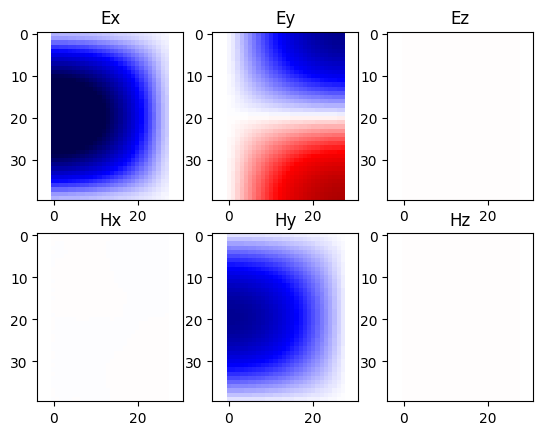

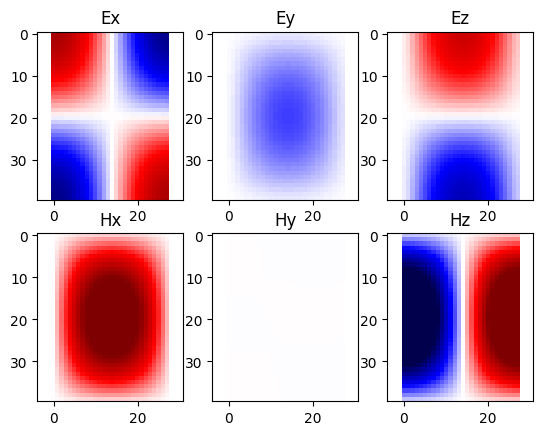

In [2]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
layers = {
    "wg": LayerLevel(
        layer=LogicalLayer(layer=WG),
        zmin=0,
        thickness=h_wg,
        material='Si',
        mesh_order=100,
    ),
    "design": LayerLevel(
        layer=LogicalLayer(layer=DESIGN),
        zmin=h_slab,
        thickness= d_etch,
        material="design",
        mesh_order=1,
    ),
}
layer_stack = LayerStack(layers=layers)

_dx = λ_SiO2 / nres
nr = round(R/_dx)
_dx=R/nr

if bidirectional:
    x =y= np.linspace(_dx/2,R-_dx/2, nr)
else:
    x = np.linspace(-R+_dx/2,R-_dx/2,2*nr)
    y = np.linspace(_dx/2,R-_dx/2, nr)
X, Y = np.meshgrid(x, y, indexing='ij')
g = np.exp(-(X**2 + Y**2) / (2 * (w/2) ** 2))

wg_mode=lumi.Mode(
        ports=['o2'],
        start=[-w_wg/4, -height_port_margin],
        stop=[w_wg / 4+lateral_port_margin, h_wg + height_port_margin],
        boundaries=[('PEC','PML'),'PML']
    )
if bidirectional:
    source_mode=lumi.Mode(
        ports=[source_port],
         fields={
            "Ey": g,
            "Hx": -g * n_SiO2,
        },
        start=[0, 0],
        stop=[R,R],
        boundaries=[('PMC','PML'),('PEC','PML')]
    )
else:
    source_mode=lumi.Mode(
        ports=[source_port],
        fields={
            "Ey": g,
            "Hx": -g * n_SiO2,
        },
        start=[-R, 0],
        stop=[R,R],
        boundaries=['PML',('PEC','PML')]
    )
modes = [wg_mode, source_mode]


# additional ports not attached to gdsfactory component
ports = [
    lumi.PlanePort(
        name=source_port,
        origin=[0, 0, z_port],
        frame=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    )
]

sources = [
    lumi.Source(
        source_port,
        wavelength=wavelength,
        bandwidth=wavelength / 5,
        source_port_margin=source_port_margin,
    )
]

targets =        [
            lumi.Target(
                key=f"To2@0,{source_port}@0",
                target=1,
                weight=1 / len(wavelengths),
                wavelength=wl,
                func="relu-",
            )
            for wl in wavelengths        ]

tmax = 1.3 *(
    ( 6*(h_wg*n_Si+gap2*n_SiO2)+(source_port_margin+gap1)*n_SiO2) 
    + (l_wg +l_design + w_design+R)* n_Si
) / wavelength

lmin_design = 0.065
designs = [
    lumi.Design(
        "design",
        layer=DESIGN,
        lmin=lmin_design,
        fill_material='Si',
        void_material='SiO2',
        uniform_along="z",
    ),
]

optimizer = lumi.Optimizer(
    stoploss=0.1,
    # lowloss=0.4,
    iters=30,  # max iters
    momentum=0.8,
    # contrast=1.0,
)

boundaries = ['PML', ['PEC',"PML"], ["PEC", "PML"]]
relative_pml_depths = [.7, 0.3, 0.7]  # relative PML thicknesses in x, y, z

labels={
    # 'o1':'λ = 1311nm',
}

if bidirectional:
    mirrors=['x-','y-']
else:
    mirrors=['y-']
views = [
    lumi.View("Ey",y=0, z=d_etch / 2 + h_slab,mirrors=mirrors,show_box=False,material_color_intensity=5),
]

relative_courant = 0.95
saveat = 25  # save frame every `saveat` periods for movie

lumi.make(
    #
    path=path,  # path to make problem folder
    component=c,
    wavelength=wavelength,
    wavelengths=wavelengths,
    ports=ports,
    modes=modes,
    sources=sources,
    boundaries=boundaries,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    zmin=zmin,  # zmin of simulation region
    zmax=zmax,  # zmax of simulation region
    #
    nres=nres,
    tmax=tmax,  # total simulation time in periods
    relative_pml_depths=relative_pml_depths,
    relative_courant=relative_courant,
    saveat=saveat,
    #
    views=views,
    # inverse design parameters
    # load_saved_designs=True,
    designs=designs,
    targets=targets,
    optimizer=optimizer,
)
raise SystemExit

In [ ]:
nres=6
saveat=1
wavelengths=np.linspace(1.5,1.6,101)
tmax=40
path0=path
path=path0+'_final'
os.system(f'cp -r {path0}/designs/ {path}')
lumi.make(
    #
    path=path,  # path to make problem folder
    component=c,
    wavelength=wavelength,
    wavelengths=wavelengths,
    ports=ports,
    modes=modes,
    sources=sources,
    boundaries=boundaries,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    zmin=zmin,  # zmin of simulation region
    zmax=zmax,  # zmax of simulation region
    #
    nres=nres,
    tmax=tmax,  # total simulation time in periods
    relative_pml_depths=relative_pml_depths,
    relative_courant=relative_courant,
    saveat=saveat,
    #
    views=views,
    # inverse design parameters
    load_saved_designs=True,
    designs=designs,
)
raise SystemExit

Video generated successfully at /home/weihu/lumi/luminescent/studies/PVGC/simulation.gif!


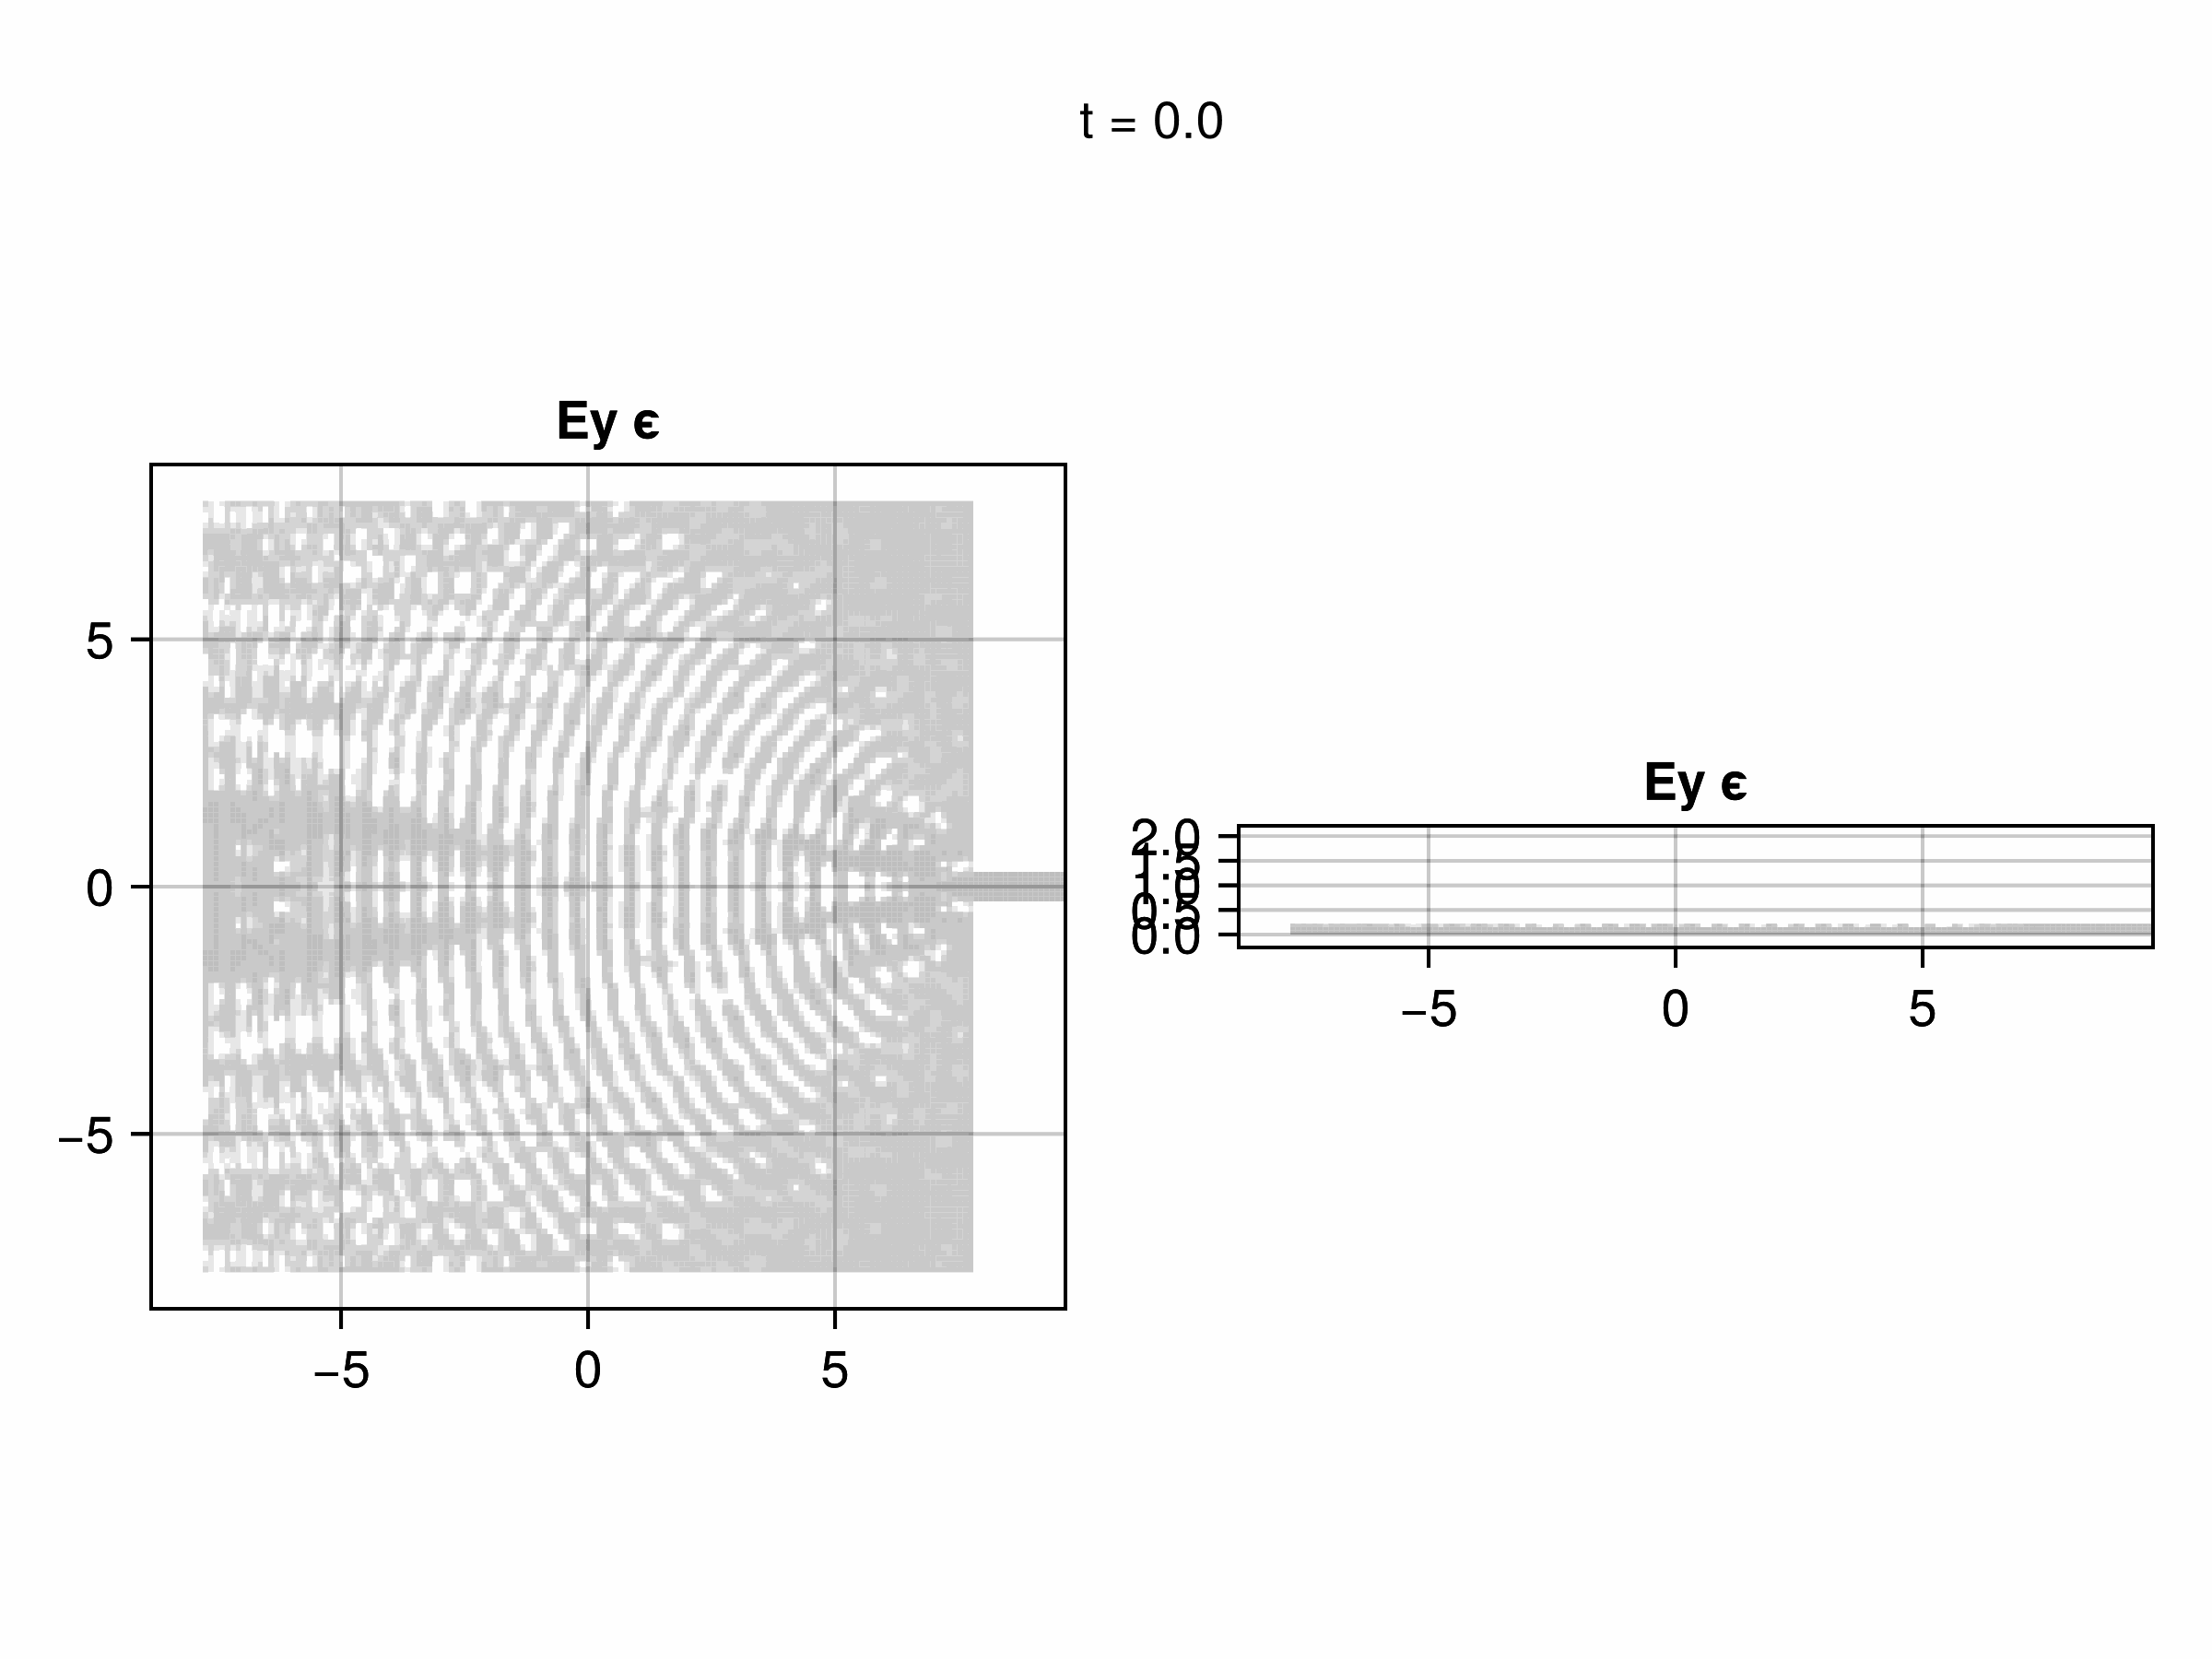

In [3]:
lumi.movie(path,views,1)#,run=False)

In [ ]:
plt.close()
sol = lumi.load(path)
x = wavelengths

y = lumi.query(sol, "To2@0,o1@0")  # wavelength or frequency ordered depending on problem setup
y=[10*np.log10(y) for y in y]

plt.plot(x, y)
plt.xlabel("wavelength [um]")
plt.ylabel("S21 [dB]")
plt.show()